## 0. Import Required Packages

In [2]:
#a super learner model for regression
from math import sqrt
from numpy import vstack
from numpy import asarray
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

C:\Users\gamze\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import pandas as pd
from numpy import hstack
from numpy import array
import pygeostat as gs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
%pylab inline --no-import-all
from subprocess import check_output
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Using TensorFlow backend.


## 1. Grid Definition  and Dataset Description

In [4]:
griddef = gs.GridDef(gridfl='griddef.txt')
griddef

Pygeostat GridDef:
35 500.0 100.0 
60 5000.0 100.0 
15 145.0 10.0

### Produce blind dataset

In [5]:
kfold = gs.Program('./packages/kfold', getpar=True)

C:\Users\gamze\Desktop\CCG Codes\CCG Paper 3\Oilsands SK - comparision\tmpcjfc64ac\kfold.par has been copied to the clipboard


In [6]:
## Create Datanew = Training01
##        Datatest = Validation01

parstr = """                  Parameters for KFOLD
                  ********************

START OF PARAMETERS:
oilsands.dat                     -file with data
1   2 3 4    5               -   columns for DH,X,Y,Z,VR
-1.0     1.0e21              -   trimming limits
kfold.out                    -file for output
1                            -write Validation and Training files?
10                            -number of folds
1324978                      -random number seed
0.001  0.01  0.25   0.50      -weights: random, centroid, diff, same
"""
kfold.run(parstr)
kfold_fl = gs.DataFile('kfold.out',griddef=griddef)

### Load the data

In [7]:
datafl = gs.DataFile(flname='Datanew.dat',readfl=True,dh='Drillhole Number', x='East',y='North',z='Elevation', griddef = griddef)
print(pd.DataFrame(datafl.unique_cats('Drillhole Number')).shape)

(251, 1)


In [9]:
## Blind Data
testfl = gs.DataFile(flname='Datatest.dat', griddef = griddef,
                       readfl=True)

### Summary statistics and Location maps

In [10]:
datafl.describe()

,Bitumen,Fines,Chlorides,Facies Code,Fold (out of 10)
count,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000
mean,7.802674,28.219123,104.202628,39.996357,6.003451
std,5.143799,21.075424,292.122697,24.739544,2.577353
min,0.000000,0.887000,-9.000000,-9.000000,2.000000
25%,2.955500,9.817500,-9.000000,50.000000,4.000000
50%,7.624500,23.680000,5.700000,50.000000,6.000000
75%,12.782000,42.197750,64.750000,50.000000,8.000000
max,18.428000,86.777000,2602.000000,70.000000,10.000000


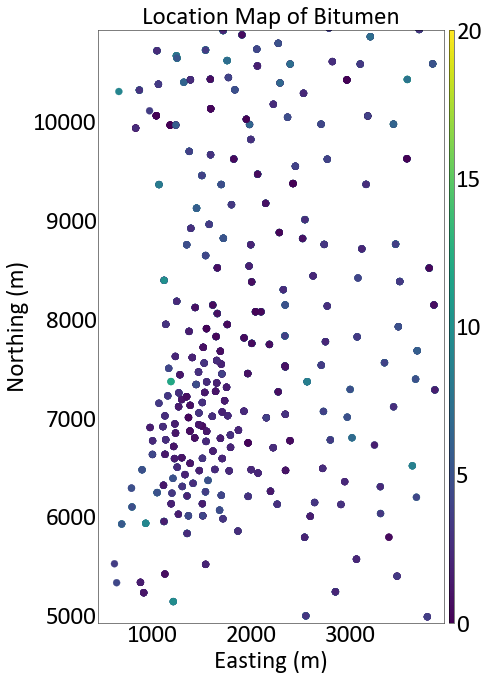

In [11]:
gs.set_style('pt25')

gs.locmap(datafl,var = 'Bitumen',orient='xy', sliceno= 20,slicetol=10, title = ('Location Map of Bitumen'), figsize=(10,10), vlim = (0,20))

plt.tight_layout()


### Declustering

In [12]:
declus = gs.Program('./packages/declus', getpar=True)

C:\Users\gamze\Desktop\CCG Codes\CCG Paper 3\Oilsands SK - comparision\tmpv41dwpbu\declus.par has been copied to the clipboard


In [13]:
declusparstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
{datafl}         -file with data
{xyzcol}   {varcol}               -  columns for X, Y, Z, and variable
-1.0e21     1.0e21            - trimming limits
declus_ful.sum                  -file for summary output
declus_ful.out                  -file for output with data & weights
1   1                  -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
100  10.0  200               -number of cell sizes, min size, max size
20                           -number of origin offsets
"""
Data = gs.DataFile(flname='Datanew.dat', griddef = griddef, readfl=True)

declus.run(declusparstr.format(datafl = Data.flname,
                           xyzcol = Data.gscol(Data.xyz),
                           varcol = Data.gscol('Bitumen')))
declus_fl = gs.DataFile('declus_ful.out',griddef=griddef)

Calling:  ['./packages/declus', 'temp']

 DECLUS Version: 3.001

  data file = Datanew.dat                             
  columns =            2           3           4           5
  tmin,tmax =  -1.0000000E+21  1.0000000E+21
  summary file = declus_ful.sum                          
  output file = declus_ful.out                          
  anisotropy =    1.000000       1.000000    
  minmax flag =            0
  ncell min max =          100   10.00000       200.0000    
  offsets =           20
 

 There are     5216 data with:
   mean value            =      7.80267
   minimum and maximum   =      0.00000    18.42800
   size of data vol in X =   3264.60986
   size of data vol in Y =   5957.88965
   size of data vol in Z =    129.00000

   declustered mean      =      7.00758
   min and max weight    =      0.42762     4.32931
   equal weighting       =      1.00000


 DECLUS Version: 3.001 Finished



In [14]:
declus_sum = gs.DataFile('declus_ful.sum') 
declus_sum.head()

,Cell Size,Declustered Mean
0,0.0,7.802671
1,10.0,7.480504
2,11.9,7.437216
3,13.8,7.357739
4,15.7,7.297101


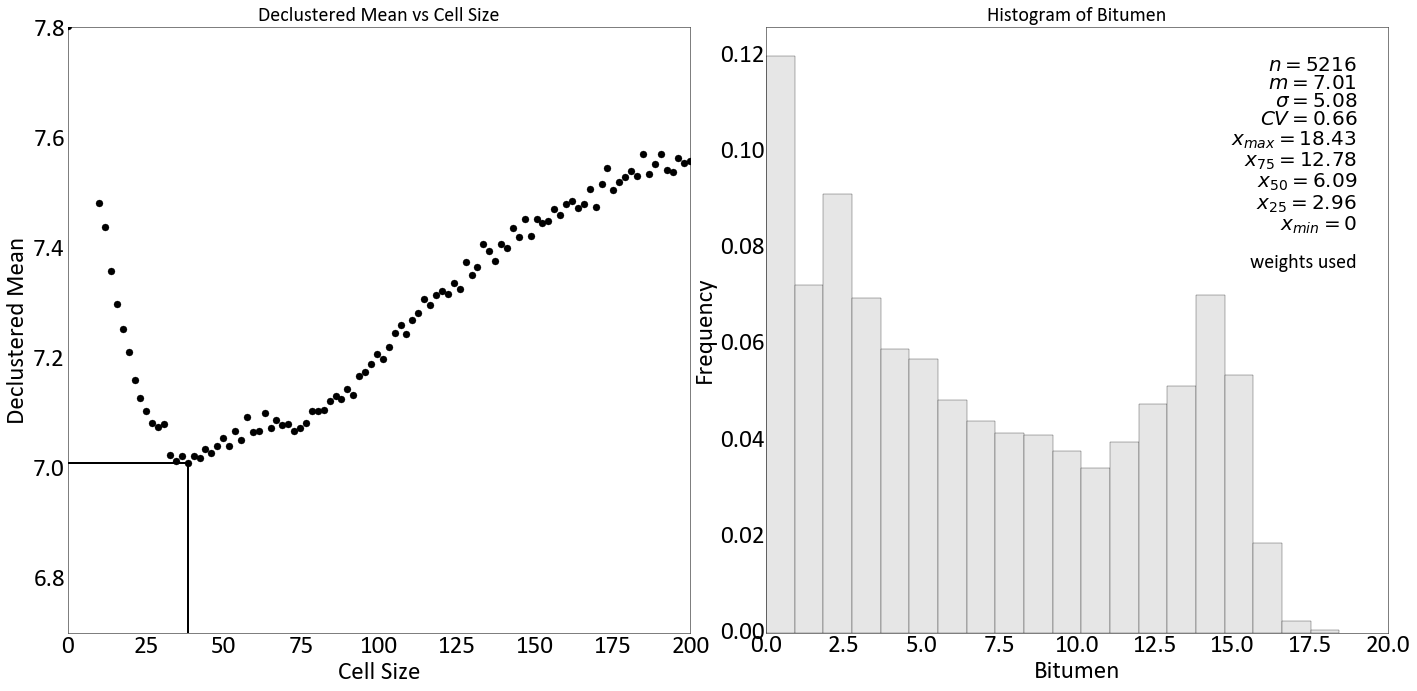

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gs.set_style('pt20')
ax1.scatter(declus_sum.data['Cell Size'], declus_sum.data['Declustered Mean'], c = 'Black')
ax1.set_title('Declustered Mean vs Cell Size')
ax1.set_xlabel('Cell Size')
ax1.set_ylabel('Declustered Mean')
ax1.set_xlim(0,200)
ax1.set_ylim(6.7, 7.8)
ax1.plot([38.5,38.5], [6.7, 7.00758], 'k-', lw=2)
ax1.plot([0,38.5], [7.00758,7.00758], 'k-', lw=2)
plt.tight_layout()
gs.histplt(declus_fl,var='Bitumen',wt='Declustering Weight',title = 'Histogram of Bitumen',bins=20,xlim=(0,20),ax=ax2)

plt.savefig('./Figures/Declustered data.png')


## 3.  Data split for CV

In [16]:
kfold = gs.Program('./packages/kfold', getpar=True)

C:\Users\gamze\Desktop\CCG Codes\CCG Paper 3\Oilsands SK - comparision\tmpjeh1rsx8\kfold.par has been copied to the clipboard


In [17]:
parstr = """                  Parameters for KFOLD
                  ********************

START OF PARAMETERS:
Datanew.dat                     -file with data
1   2 3 4    5               -   columns for DH,X,Y,Z,VR
-1.0     1.0e21              -   trimming limits
kfold.out                    -file for output
1                            -write Validation and Training files?
5                            -number of folds
1324978                      -random number seed
0.001  0.01  0.25   0.50              -weights: random, centroid, diff, same
"""
kfold.run(parstr)
kfold_fl = gs.DataFile('kfold.out',griddef=griddef)

## 4. Variogram Calculation,  Modeling and Kriging for folds

In [18]:
varcalc = gs.Program('./packages/varcalc')
varmodel = gs.Program('./packages/varmodel')
kt3dn = gs.Program('./packages/kt3dn')
declus = gs.Program('./packages/declus') 

In [19]:
declusstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
{datafl}         -file with data
{xyzcol}   {varcol}               -  columns for X, Y, Z, and variable
-1.0e21     1.0e21            - trimming limits
declus/declus_{fold}.sum                  -file for summary output
declus/declus_{fold}.out                  -file for output with data & weights
1   1                  -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
100  10.0  200               -number of cell sizes, min size, max size
20                           -number of origin offsets
"""
varcparstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{datafl}                 -file with data
{xyzcol}                         -   columns for X, Y, Z coordinates
1   {varcol}                            -   number of variables,column numbers (position used for tail,head variables below)
-99.0    1.0e21                  -   trimming limits
3                                 -number of directions
40 22.5 1000 0.0 22.5 9 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 27  70  35                  -        number of lags,lag distance,lag tolerance
130 22.5 1000 0.0 22.5 9 0.0    -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 27  70  35                  -        number of lags,lag distance,lag tolerance
0.  5  1000 -90 5 1000 0.0    -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 8 2 1                -        number of lags,lag distance,lag tolerance
./vargs/varcalc_{fold}.out                      -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1          200                       -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   1   ?                     -tail variable, head variable, variogram type (and cutoff/category), sill

"""
varmparstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
./vargs/varmodel_{fold}.out                 -file for modeled variogram points output
3                            -number of directions to model points along
  40 0.0  4000   0.5      -  azm, dip, npoints, point separation
  130 0.0  4000   0.5      -  azm, dip, npoints, point separation
  0.0  90.0  1000   0.5      -  azm, dip, npoints, point separation
2    0.07:0.08             -  nst, nugget effect
2    0.25  40.0   0.0   0.0    -it,cc,ang1,ang2,ang3
        400.0  300.0  25.0    -a_hmax, a_hmin, a_vert
2    0.67  40.0   0.0   0.0    -it,cc,ang1,ang2,ang3
      8000.0 4500.0  30.0    -a_hmax, a_hmin, a_vert
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc}                  -    experimental output file 1
3   1  2  3                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
./vargs/varmodel_{fold}.var              -  file to save fit variogram model
"""
kt3dnparstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}                            -file with data
0  {xyzcol} {varcol}  0             -  columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
2 3  4 5 0                      -   columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
0    15.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             -file for debugging output (see note)
./predictions/kt3dn_{fold}.out         -file for kriged output (see GSB note)
{griddef}
4   4   4                       -x,y and z block discretization
6    60    12    1               -min, max data for kriging,upper max for ASO,ASO incr
0      0                         -max per octant, max per drillhole (0-> not used)
4000.0  4000.0  4000.0           -maximum search radii
 0     0        0                 -angles for search ellipsoid
0                               -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
{mean} 0.6  0.8                  -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.out                     -gridded file with drift/mean
4                                -  column number in gridded file
key_out.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
2    0.08                     -nst, nugget effect
2    0.25  40.0   0.0   0.0    -it,cc,ang1,ang2,ang3
        400.0  300.0  25.0    -a_hmax, a_hmin, a_vert
2    0.67  40.0   0.0   0.0    -it,cc,ang1,ang2,ang3
      8000.0 4500.0  30.0    -a_hmax, a_hmin, a_vert
"""

In [20]:
 for fold in range(1,6):
    Traindat = gs.DataFile('Training0{}.dat'.format(fold),griddef=griddef)

    declus.run(declusstr.format(datafl = Traindat.flname,
                         xyzcol = Traindat.gscol(Traindat.xyz),
                         varcol = Traindat.gscol('Bitumen'),
                         fold = fold))
    
    mean = np.min(np.asarray(gs.DataFile('declus/declus_{}.sum'.format(fold)).data['Declustered Mean']
                                    [gs.DataFile('declus/declus_{}.sum'.format(fold)).data['Cell Size']>0.0]))

    
    varcalc.run(varcparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('Bitumen'),
                             fold = fold))

    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))

   
    varmodel.run(varmparstr.format(varcalc = varcalcfl.flname,
                                 fold = fold))

    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))

    f = open("./vargs/varmodel_{}.var".format(fold), "r")
    varg = f.readlines()
    f.close()
    varg = ''.join(varg)
    
    kt3dn.run(kt3dnparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('Bitumen'),
                             griddef = griddef,
                             varg = varg,
                             fold = fold,
                             mean = mean))

## 5. Performance evaluation of Krigining

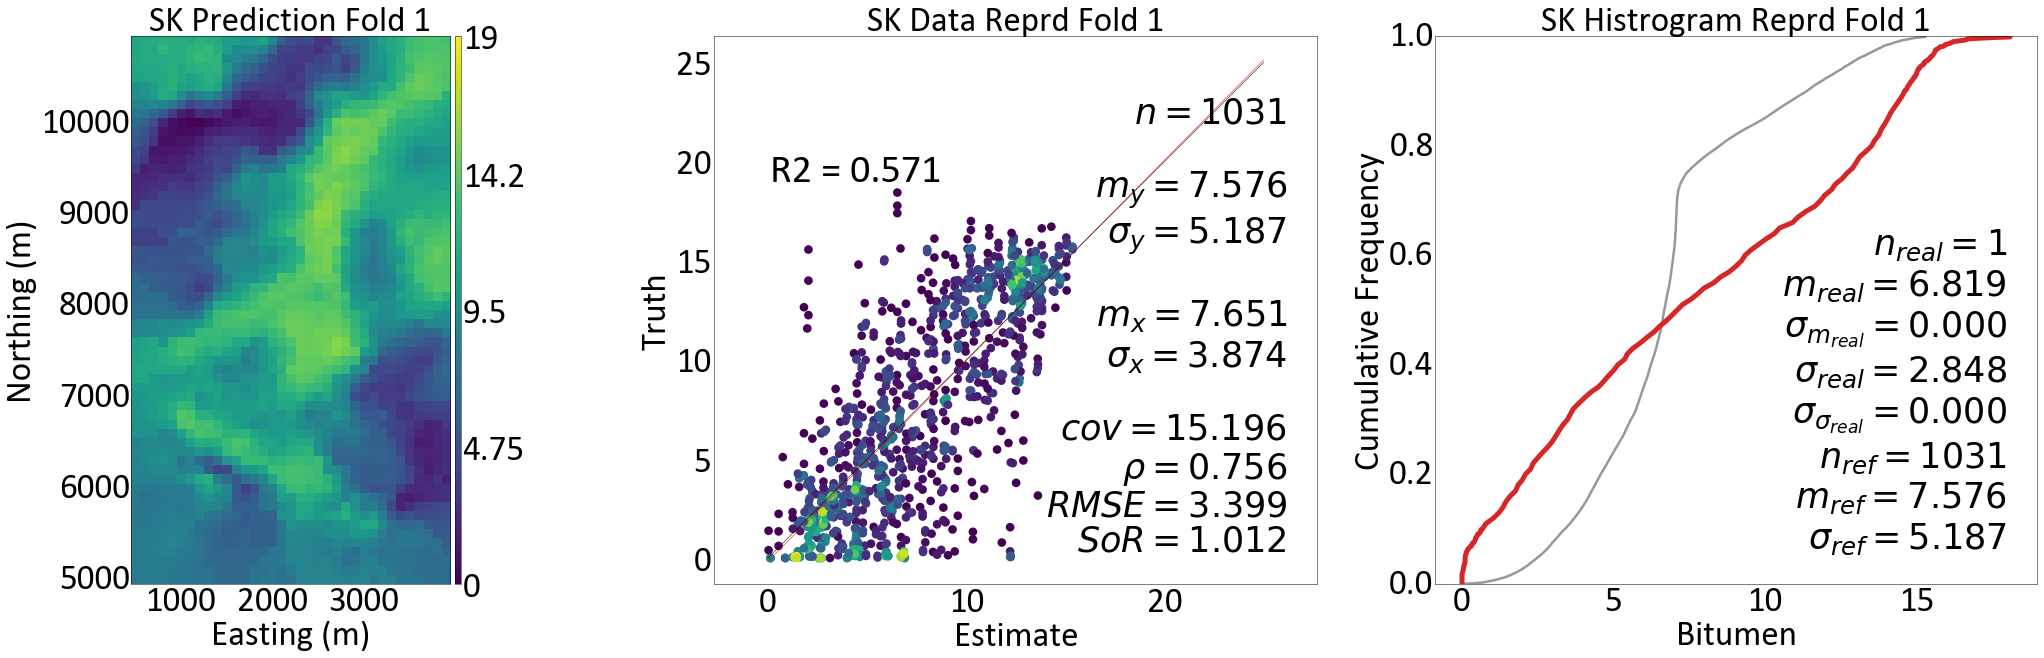

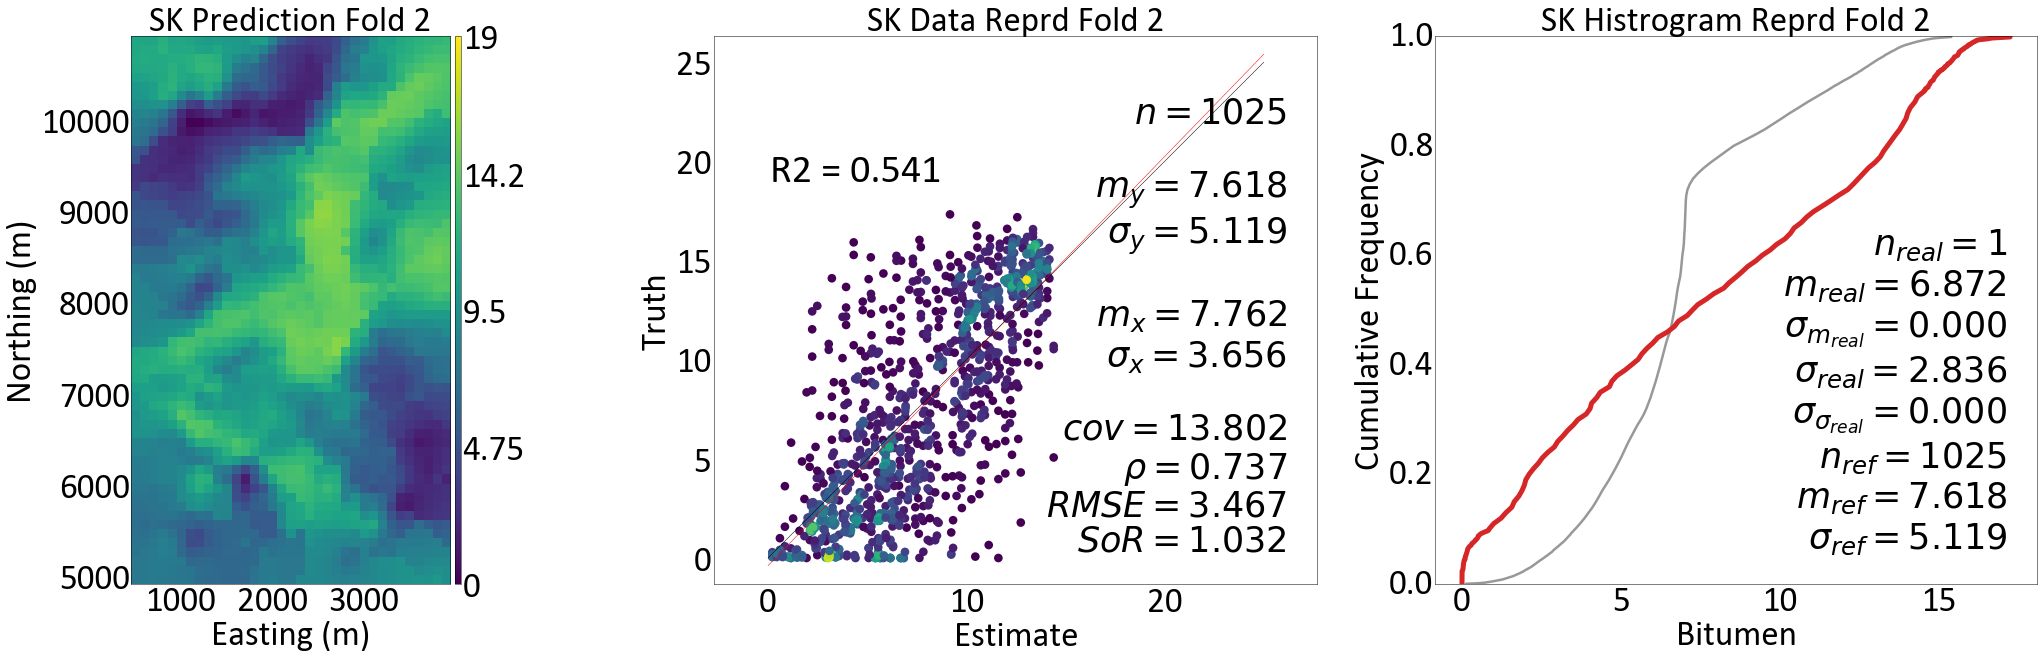

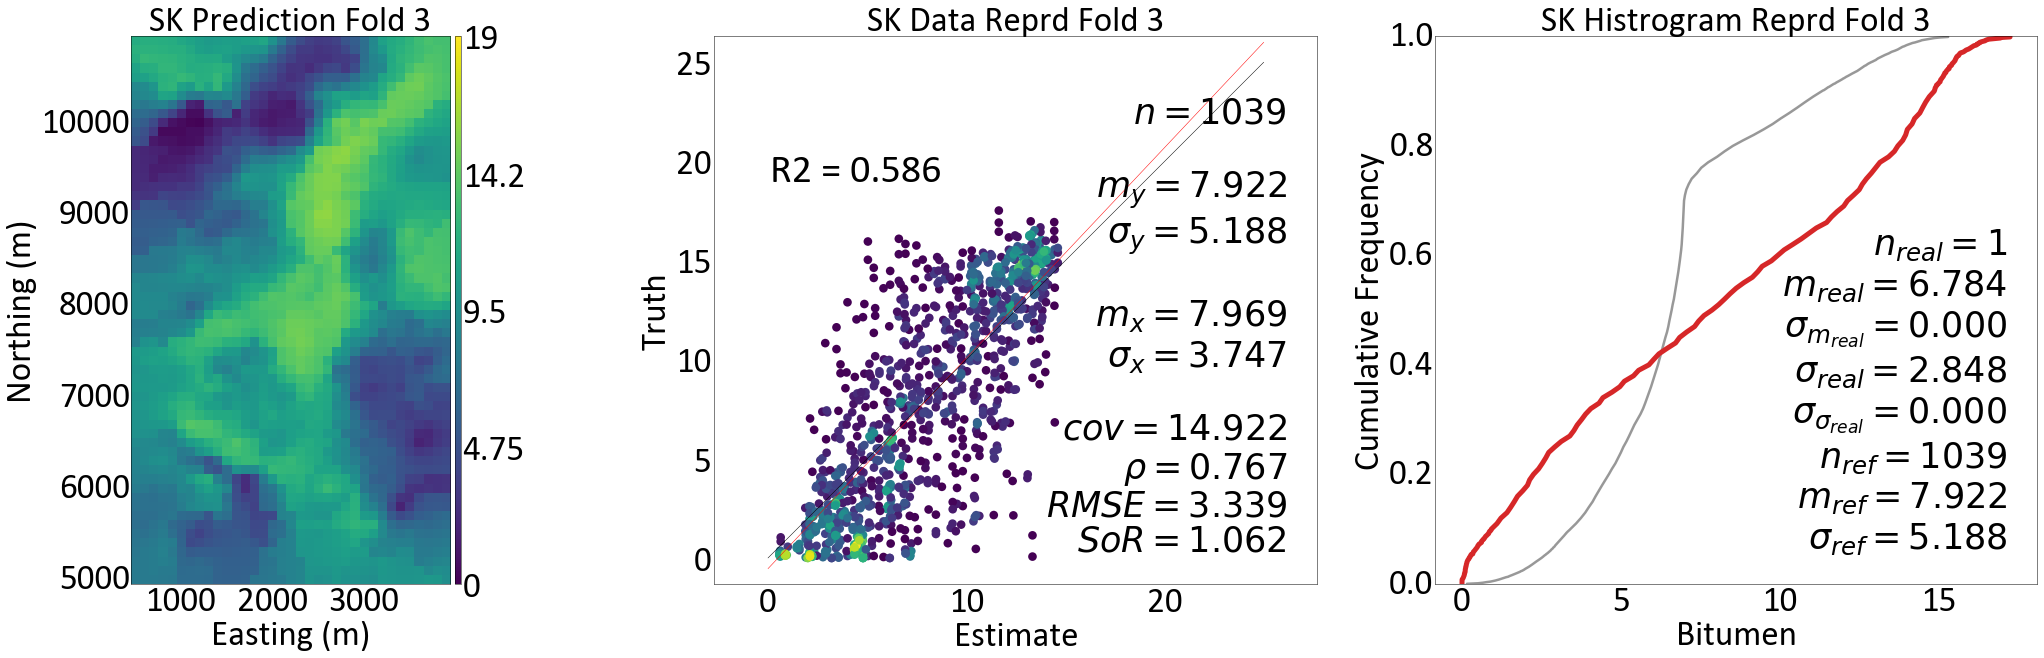

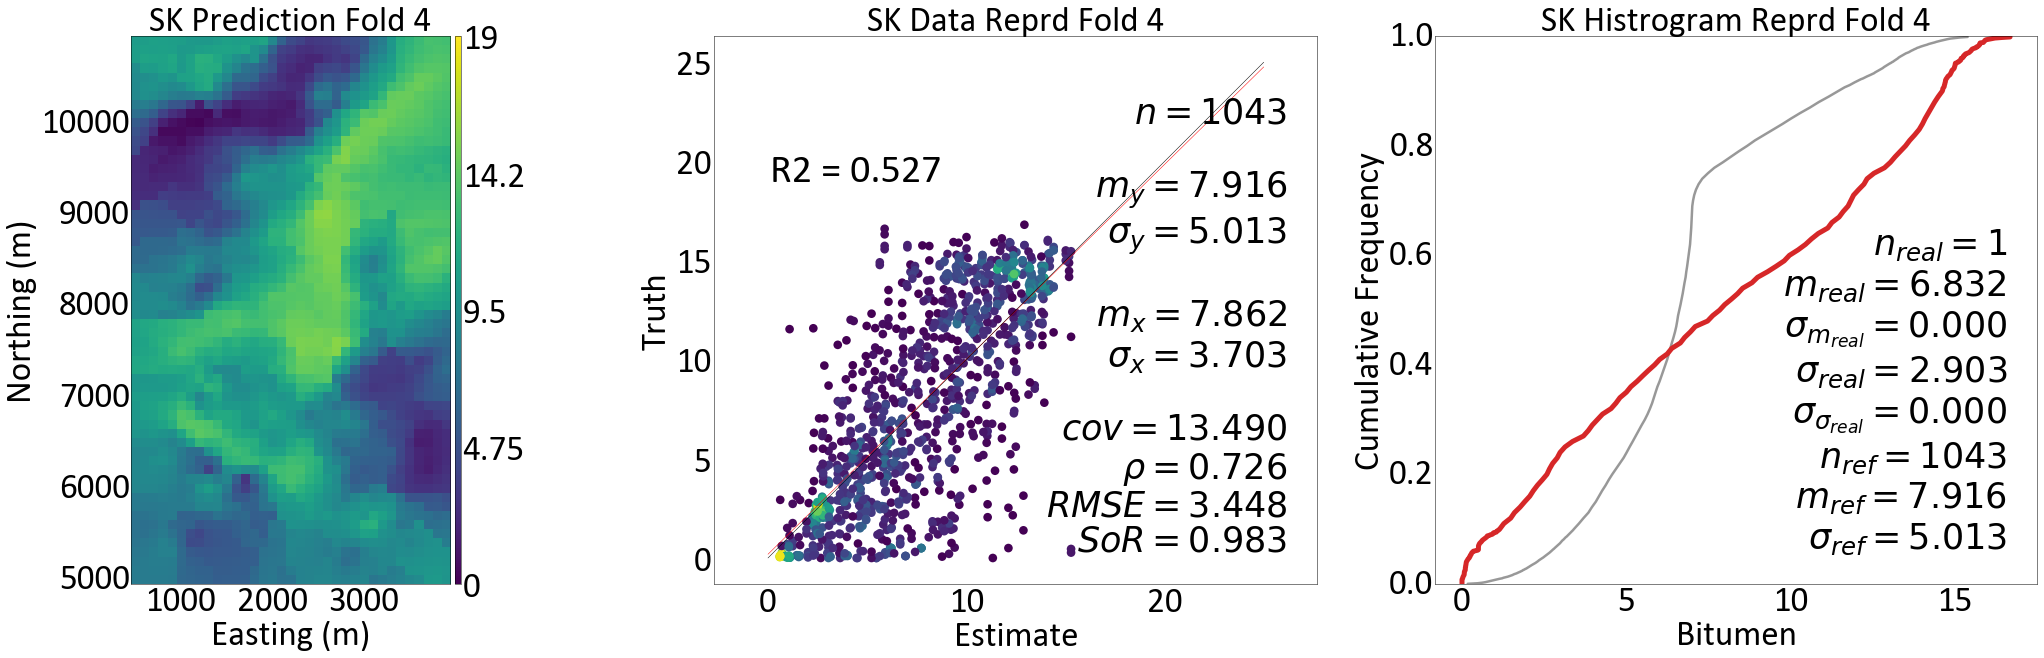

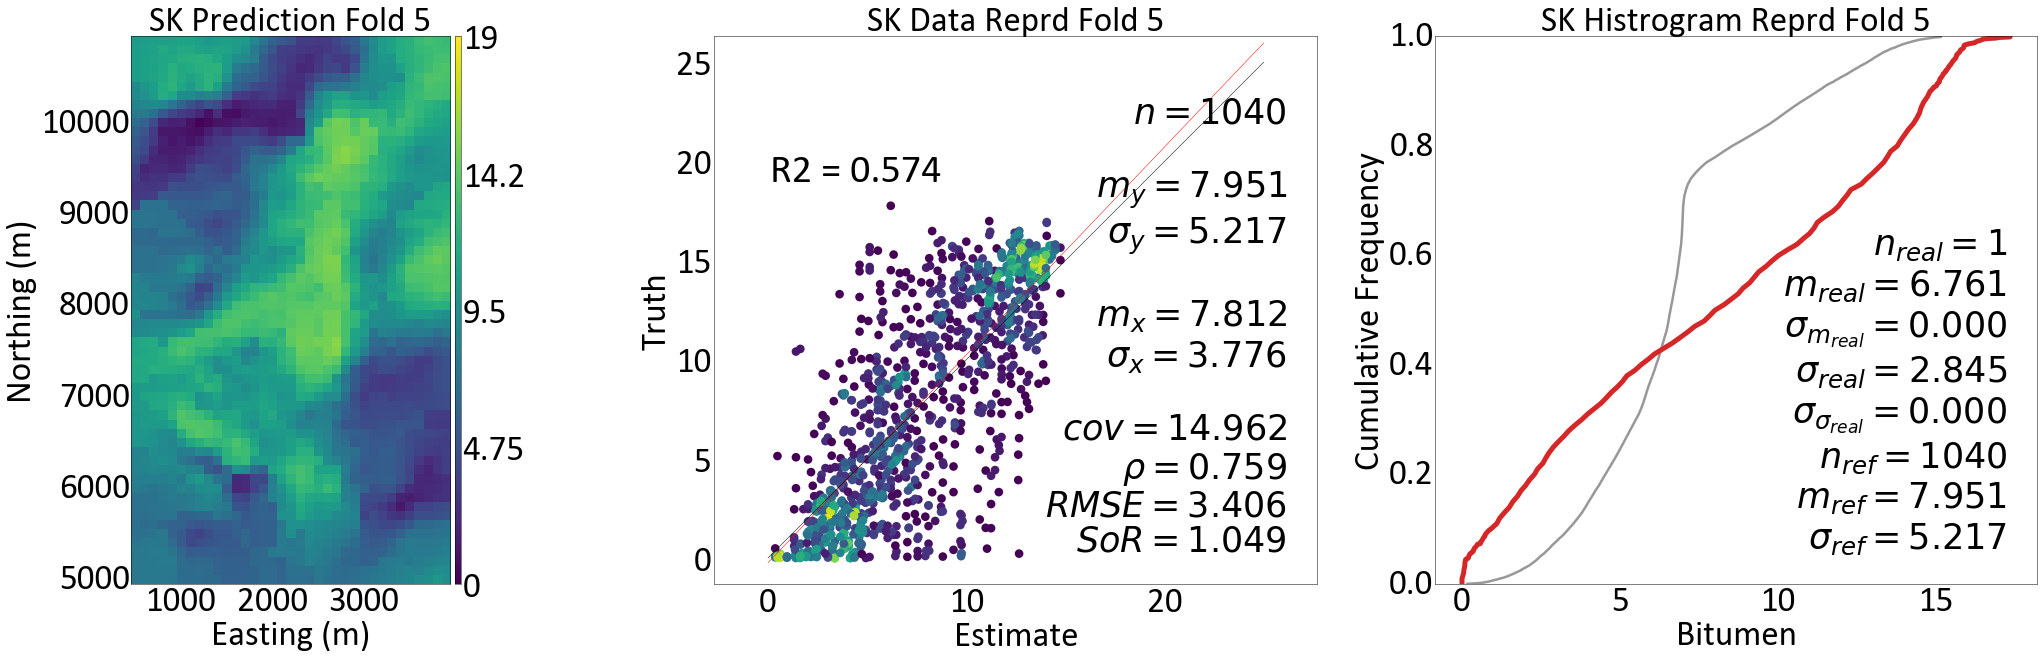

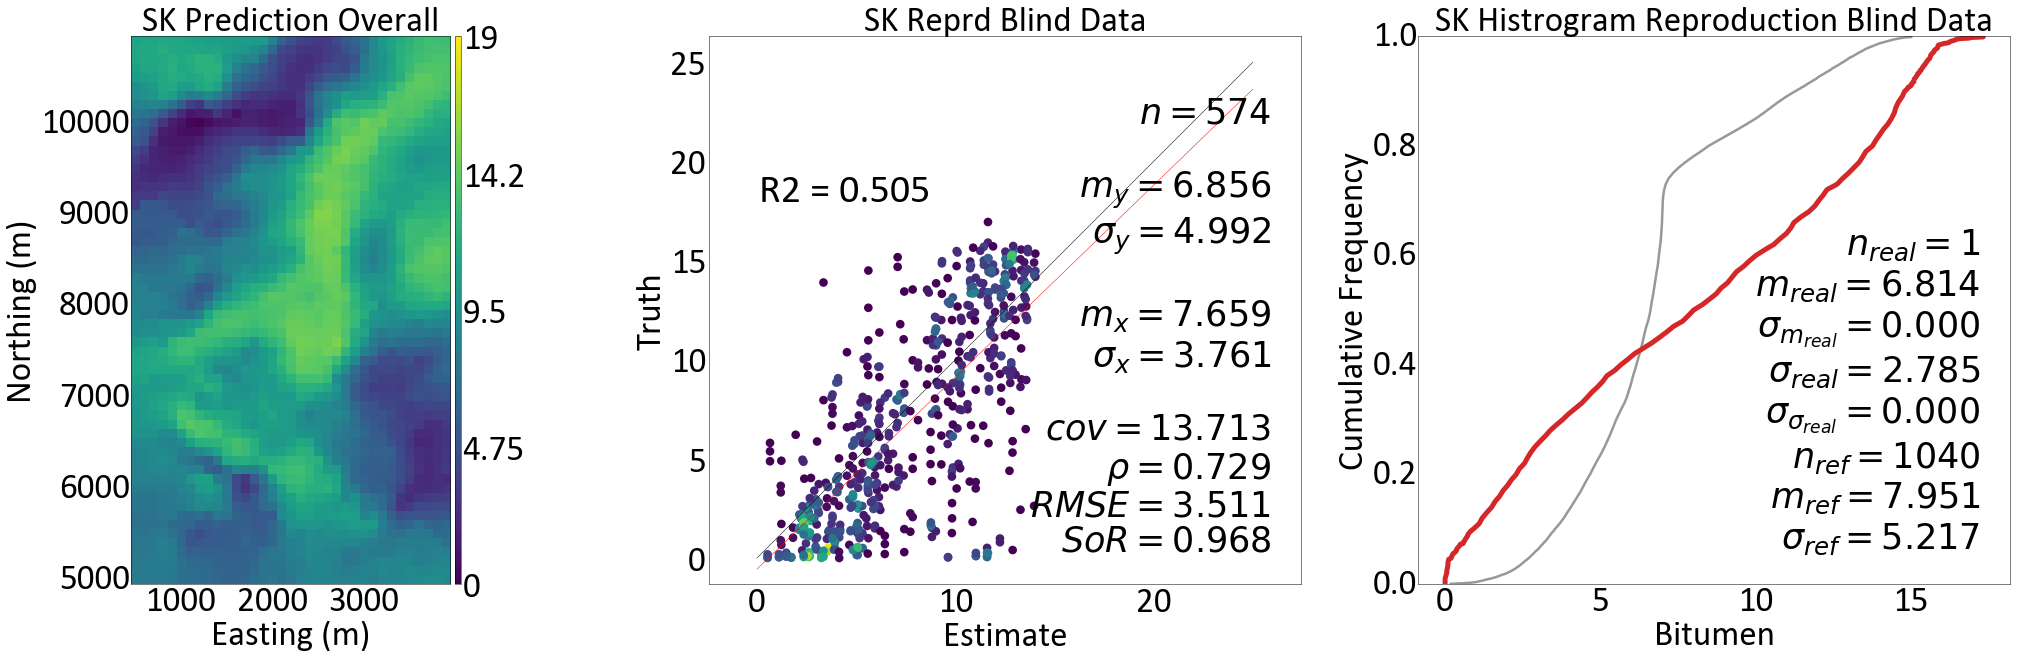

In [21]:
slinceno=9
vlim =(0,19)
pltlim = (0,25)
i=0

gs.set_style('pt35')

krig_av_est = np.zeros(shape=(31500,1))
krig_av_std = np.zeros(shape=(31500,1))


KRG_R2 = 0
KRG_RMSE = 0


for Fold in range(0,5):
    Fold +=1
    i += 1
    testfile = gs.DataFile('Validation0{}.dat'.format(Fold))
    pltdat_kt3dn = gs.DataFile('./predictions/kt3dn_{}.out'.format(Fold),griddef=griddef)
    test= gs.DataFile('Datatest.dat', griddef= griddef)
    
    krig_av_est = krig_av_est +  pltdat_kt3dn.data['Estimate'].values.reshape(len(pltdat_kt3dn.data['Estimate']),1)
    krig_av_std = krig_av_std +  pltdat_kt3dn.data['EstimationVariance'].values.reshape(len(pltdat_kt3dn.data['Estimate']),1)
    

    idx,ingrid = griddef.coord_to_index1d(x=testfile.data['East'],y=testfile.data['North'],z=testfile.data['Elevation'])
    idx_2,ingrid = griddef.coord_to_index1d(x=test.data['East'],y=test.data['North'],z=test.data['Elevation'])
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx>=0]

    
    ###############################################################################################################  
    
    f, axes = plt.subplots(1, 3, figsize=(30, 10))
    ax2 = gs.pixelplt(pltdat_kt3dn,ax = axes[0],
                title = 'SK Prediction Fold {}'.format(Fold),vlim=vlim, sliceno=slinceno)
    
    ax3 = gs.scatxval(pltdat_kt3dn.data['Estimate'][idx].values,testfile.data['Bitumen'],xlabel='Estimate', ylabel='Truth',ms=75,
        title = 'SK Data Reprd Fold {}'.format(Fold),dens=True,ax = axes[1],vlim=pltlim)
    axes[1].text(0.1,19,'R2 = {0:.3f}'.format(r2_score(testfile.data['Bitumen'],pltdat_kt3dn.data['Estimate'][idx].values)),size=40)
    
    ax4 = gs.histpltsim(pltdat_kt3dn.data['Estimate'],testfile.data['Bitumen'],
                        title = 'SK Histrogram Reprd Fold {}'.format(Fold),lw=5,ax=axes[2],griddef=griddef,nreal=1)
    plt.tight_layout()
    plt.savefig('./Figures/pixlpltxy_{}.png'.format(Fold))
    plt.show()
    
    ################################################################################################################     
 
    KRG_R2 = KRG_R2 + r2_score(testfile.data['Bitumen'],pltdat_kt3dn.data['Estimate'][idx].values)
    KRG_RMSE = KRG_RMSE + mean_squared_error(testfile.data['Bitumen'],pltdat_kt3dn.data['Estimate'][idx].values)

    ################################################################################################################ 
    
krig_av_est = pd.DataFrame((krig_av_est/i),columns = ['Estimate'])

test = pd.DataFrame((test.data),columns = ['Bitumen'])
idx_2 = pd.DataFrame((idx_2),columns = ['0'])

test = test['Bitumen'][idx_2['0'] >= 0]
idx_2 = idx_2['0'][idx_2['0'] >= 0]


#    ################################################################################################################ 
    
f, axes = plt.subplots(1, 3, figsize=(30,10))

ax2 = gs.pixelplt(krig_av_est['Estimate'],ax = axes[0],griddef=griddef,
            title = 'SK Prediction Overall',vlim=vlim, sliceno=slinceno)

ax3 = gs.scatxval(krig_av_est['Estimate'][idx_2].values,test,xlabel='Estimate', ylabel='Truth',ms=75,
    title = 'SK Reprd Blind Data',dens=True,ax = axes[1],vlim = pltlim)
axes[1].text(0.1,18,'R2 = {0:.3f}'.format(r2_score(test,krig_av_est['Estimate'][idx_2].values)),size=40)

ax4 = gs.histpltsim(krig_av_est['Estimate'],testfile.data['Bitumen'],lw=5,ax=axes[2],
                    griddef=griddef,nreal=1,title = 'SK Histrogram Reproduction Blind Data')

plt.tight_layout()
plt.savefig('./Figures/histplt_Overall.png')
plt.show()



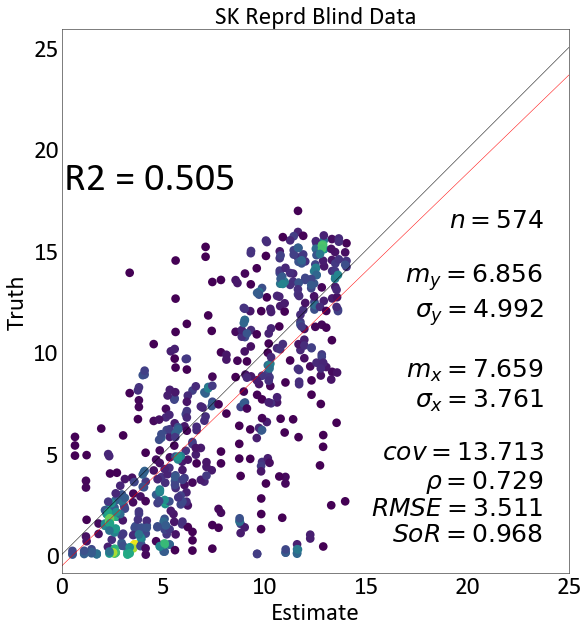

In [22]:
gs.set_style('pt25')
plt.rcParams.update({'font.size': 20})

f, axes = plt.subplots(1, 2, figsize=(20,10))

ax1 = gs.scatxval(krig_av_est['Estimate'][idx_2].values,test,xlabel='Estimate', ylabel='Truth',ms=75,
    title = 'SK Reprd Blind Data',dens=True,ax = axes[0],vlim = pltlim)
axes[0].text(0.1,18,'R2 = {0:.3f}'.format(r2_score(test,krig_av_est['Estimate'][idx_2].values)),size=40)

axes[-1].remove()